In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from time import time

DATA_PATH = "../data/cifar-10-batches-py/"

def unpack(fname):
    import pickle
    with open(fname, "rb") as fin:
        dumped = pickle.load(fin, encoding="bytes")
    return dumped

train_input = []
train_oh_output = []
train_output = []
for i in range(5):
    raw_train_data = unpack(DATA_PATH + "data_batch_" + str(i+1))
    train_input.append(np.array(raw_train_data[b"data"], dtype=float) / 255)
    train_oh_output.append(np.array([[1 if x == label else 0 for x in range(10)] for label in raw_train_data[b"labels"]]))
    train_output.append(np.array(raw_train_data[b"labels"]))
train_input = np.concatenate(train_input)
train_oh_output = np.concatenate(train_oh_output)
train_output = np.concatenate(train_output)

raw_test_data = unpack(DATA_PATH + "test_batch")
test_input = np.array(raw_test_data[b"data"], dtype=float) / 255
test_oh_output = np.array([[1 if x == label else 0 for x in range(10)] for label in raw_test_data[b"labels"]])
test_output = np.array(raw_test_data[b"labels"])

In [2]:
print(train_input.shape)
print(train_oh_output.shape) # one-hot output train data
print(train_output.shape)
print(test_input.shape)
print(test_oh_output.shape) # ont-hot output test data
print(test_output.shape)

(50000, 3072)
(50000, 10)
(50000,)
(10000, 3072)
(10000, 10)
(10000,)


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [11]:
def create_model(hidden_layer_size=100, activation="relu", dropout=0.2):
    model = Sequential()
    model.add(Dense(hidden_layer_size, activation=activation, input_shape=(3072,)))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=["accuracy"])
    return model

# model must be fitted with one-hot output train data

def calc_accuracy(model, test_input, test_output):
    predict = np.array([np.argmax(x) for x in model.predict(test_input)])
    return np.sum(predict == test_output) / len(predict)

# 超参交叉验证

In [12]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

## 隐藏层单元数

In [14]:
hidden_layer_sizes = np.linspace(10, 1000, 10, dtype=int)
accuracies = np.zeros((len(hidden_layer_sizes), n_splits))
for i, hidden_layer_size in enumerate(hidden_layer_sizes):
    print("cross validating", "hidden layer size", hidden_layer_size)
    accuracies[i] = np.zeros(n_splits)
    for j, (train_indices, test_indicies) in enumerate(skf.split(test_input, test_output)):
        model = create_model(hidden_layer_size = hidden_layer_size)
        model.fit(test_input[train_indices], test_oh_output[train_indices], verbose=0)
        accuracies[i][j] = calc_accuracy(model, test_input[test_indicies], test_output[test_indicies])
    print(accuracies[i])

cross validating hidden layer size 10
[0.1325 0.1585 0.147  0.17   0.132 ]
cross validating hidden layer size 120
[0.2845 0.2655 0.2715 0.2875 0.257 ]
cross validating hidden layer size 230
[0.3325 0.286  0.3155 0.334  0.285 ]
cross validating hidden layer size 340
[0.298  0.3045 0.2575 0.32   0.285 ]
cross validating hidden layer size 450
[0.29   0.3155 0.301  0.3165 0.3295]
cross validating hidden layer size 560
[0.2925 0.314  0.3095 0.301  0.286 ]
cross validating hidden layer size 670
[0.31   0.3105 0.311  0.3155 0.297 ]
cross validating hidden layer size 780
[0.3285 0.27   0.3135 0.332  0.3075]
cross validating hidden layer size 890
[0.3035 0.3335 0.3285 0.32   0.2945]
cross validating hidden layer size 1000
[0.2855 0.3265 0.336  0.323  0.316 ]


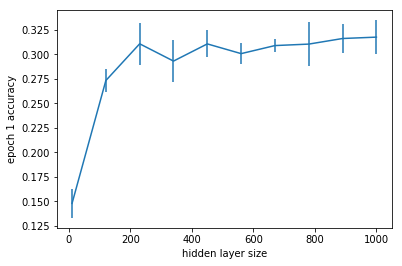

In [19]:
accuracies_mean = [np.mean(a) for a in accuracies]
accuracies_std = [np.std(a) for a in accuracies]
plt.errorbar(hidden_layer_sizes, accuracies_mean, yerr=accuracies_std)
plt.xlabel("hidden layer size")
plt.ylabel("epoch 1 accuracy")
plt.show()